In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import FluidicSetupFunctions
import numpy as np
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

In [9]:
Location = r"C:\Users\Olivi\OneDrive - TU Eindhoven\Soft robotic matter\data_analysis"
Foldernames = ["\\fluidic\\run2"]

data = FluidicSetupFunctions.LoadData(Foldernames = Foldernames,Location=Location)

Loading... Folder 1 of 1, Sample 1 of 9
Loading... Folder 1 of 1, Sample 2 of 9
Unknown sensor! XXXXXXXXXXXXX
Loading... Folder 1 of 1, Sample 3 of 9
Loading... Folder 1 of 1, Sample 4 of 9
Unknown sensor! ZZZZZZZZZZZ
Loading... Folder 1 of 1, Sample 5 of 9
Unknown sensor! ZZZZZZZZZZZ
Loading... Folder 1 of 1, Sample 6 of 9
Loading... Folder 1 of 1, Sample 7 of 9
Loading... Folder 1 of 1, Sample 8 of 9
Loading... Folder 1 of 1, Sample 9 of 9


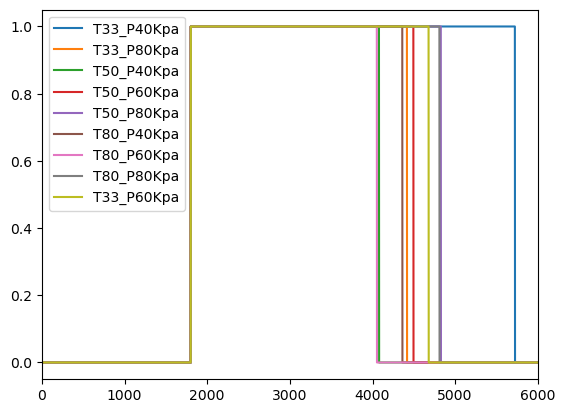

In [10]:
#Finding rising edge with convolution
def rising_edge(data, thresh):
    sign = data >= thresh
    pos = np.where(np.convolve(sign, [1, -1]) == 1)
    return pos

rising_edge(1-data[0][-2]['DigOut-1'][3000:],1)

#Make dataframe
df = pd.DataFrame()
T0=np.ones(len(data[0]))*(273+21.7)
T1 = []
p1 = []


#Extract the index where DigOut switches from 1 to 0. This indicates the timestamp when the pressure vessels are dropped in warm water.
first_index = []
samplenames = []
bb = 3000 #Start of the slice operation
for i in range(len(data[0])):
    samplename = data[1]['Samplename'][i]
    plt.plot(data[0][i]['DigOut-1'][:],label=samplename)
    plt.legend()
    indices = np.where(data[0][i]['DigOut-1'][bb:6000]<0.1) 
    first_index.append(indices[0][0]+bb)
    samplenames.append(samplename)
    T1.append(int(samplename[1:3])+273)
    

plt.xlim(0,6000)

#There is an offset in when the vessel was dropped and the DigOut was flipped, that is corrected here
samplenames[7]
first_index[7]=first_index[7]+150

#here the values from the exp, the onews to use later for ideal gas law comparison
p0 = []
p_amb=1e5
for i in range(len(data[0])):
    p0.append(data[0][i]['MPX100-2'].iloc[first_index[i]]+p_amb)
    p1.append(data[0][i]['MPX100-2'].iloc[-1]+p_amb)

In [29]:
df = pd.DataFrame({
    'T0': T0,
    'T1': T1,
    'p0': p0,
    'p1': p1,
})

#df.sort_values(by='T1',ascending=True)
df['p1_ideal']=(df['T1']/df['T0'])*df['p0']
df['dp_experiment_ideal']=df['p1_ideal']-df['p1']


#df.sort_values('T1',inplace=True)
#df=df.reset_index()
df



,T0,T1,p0,p1,p1_ideal,dp_experiment_ideal
0,294.7,306,138495.02,140965.76,143805.49,2839.73
1,294.7,306,178310.86,181203.18,185148.02,3944.84
2,294.7,323,138733.19,147477.53,152055.72,4578.19
3,294.7,323,157442.36,166630.57,172561.52,5930.95
4,294.7,323,178822.62,189179.41,195994.94,6815.52
5,294.7,353,138003.60,157849.87,165304.62,7454.75
6,294.7,353,157853.72,179698.82,189081.65,9382.83
7,294.7,353,178181.62,201299.73,213430.98,12131.25
8,294.7,306,158442.58,160859.07,164517.92,3658.85


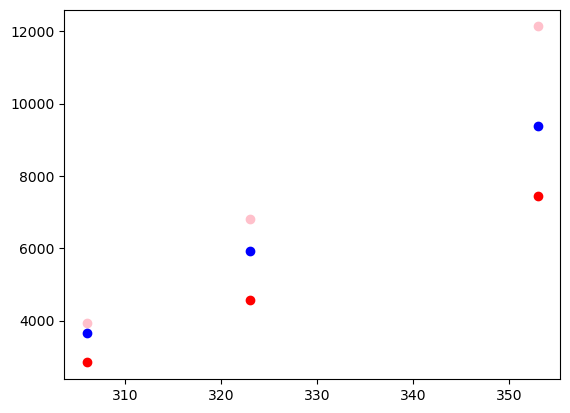

In [12]:
for dd in range(len(df['T1'])):
    if 13e4 <= df['p0'].iloc[dd] <= 14e4:
        plt.scatter(df['T1'].iloc[dd], df['dp_experiment_ideal'].iloc[dd], color='red')
    elif 15e4 <= df['p0'].iloc[dd] <= 16e4:
        plt.scatter(df['T1'].iloc[dd], df['dp_experiment_ideal'].iloc[dd], color='blue')
    else:
        plt.scatter(df['T1'].iloc[dd], df['dp_experiment_ideal'].iloc[dd], color='pink')

In [21]:
print(df['p0'].iloc[1])

178310.85642850987


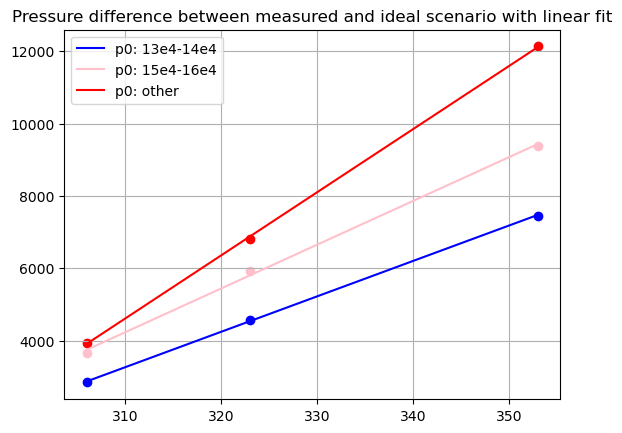

In [13]:
# Initialize the plot
plt.figure()

# Define the color for each pressure range
colors = {'13e4-14e4': 'blue', '15e4-16e4': 'pink', 'other': 'red'}

# Iterate over pressure ranges
for pressure_range, color in colors.items():
    if pressure_range == '13e4-14e4':
        mask = (13e4 <= df['p0']) & (df['p0'] <= 14e4)
    elif pressure_range == '15e4-16e4':
        mask = (15e4 <= df['p0']) & (df['p0'] <= 16e4)
    else:
        mask = ~((13e4 <= df['p0']) & (df['p0'] <= 14e4)) & ~((15e4 <= df['p0']) & (df['p0'] <= 16e4))
    
    # Select the subset of data for this pressure
    subset = df[mask]
    
    # Perform the fit
    fit = np.polyfit(subset['T1'], subset['dp_experiment_ideal'], 1)
    
    # Generate x-values for the fitted line
    x = np.linspace(subset['T1'].min(), subset['T1'].max(), 100)
    
    # Generate y-values for the fitted line
    y = np.polyval(fit, x)
    
    # Plot the data
    plt.scatter(subset['T1'], subset['dp_experiment_ideal'], color=color)
    
    # Plot the fitted line
    plt.plot(x, y, color=color, label=f'p0: {pressure_range}')

# Add a legend
plt.legend()
plt.grid()

# Display the plot
plt.title('Pressure difference between measured and ideal scenario with linear fit')
plt.show()


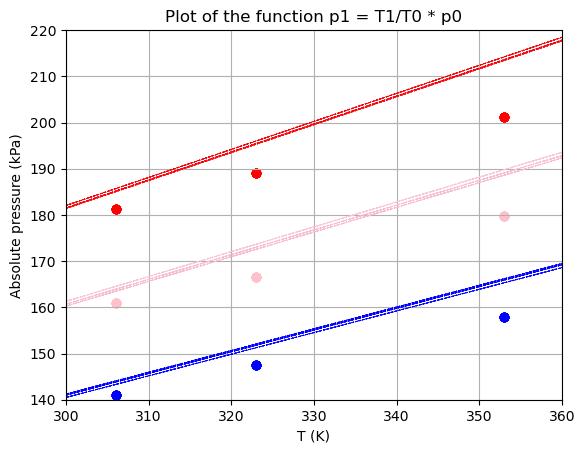

In [30]:
T =np.linspace(273,(273+100),1000)

for cc in range(len(T0)):
    p1_ideal = T/T0[cc]*(p0[cc]/1000)
    plt.plot(T,p1_ideal,color=(cc/9, cc/9, 1),linestyle ='--' ,lw=1/2)
    #plt.scatter(T1[cc],p1[cc]/1000,color=(cc/9, cc/9, 1))

    for cc in range(len(df['T1'])):
        #print(cc)
        if 13e4 <= df['p0'].iloc[cc] <= 14e4:
            p1_ideal = T/df['T0'].iloc[cc]*(df['p0'].iloc[cc]/1000)
            plt.plot(T,p1_ideal,color='blue',linestyle ='--' ,lw=1/2)
            plt.scatter(T1[cc],p1[cc]/1000,color='blue')
        elif 15e4 <= df['p0'].iloc[cc] <= 16e4:
            p1_ideal = T/df['T0'].iloc[cc]*(df['p0'].iloc[cc]/1000)
            plt.plot(T,p1_ideal,color='pink',linestyle ='--' ,lw=1/2)
            plt.scatter(T1[cc],p1[cc]/1000,color='pink')
        else:
            p1_ideal = T/df['T0'].iloc[cc]*(df['p0'].iloc[cc]/1000)
            plt.plot(T,p1_ideal,color='red',linestyle ='--' ,lw=1/2)
            plt.scatter(T1[cc],p1[cc]/1000,color='red')


plt.xlabel('T (K)')
plt.ylabel('Absolute pressure (kPa)')
plt.title('Plot of the function p1 = T1/T0 * p0')
plt.grid(True)

#custom_lines = [Line2D([0], [0], color='black', lw=2, marker='o',linestyle='None'),Line2D([0], [0], color='k', linestyle='--', lw=2)]
#plt.legend(custom_lines, ['p1($p_0$.T) Experimental', 'p1($p_0$,T) Ideal gas law'])

plt.xlim(300,360)
plt.ylim(140,220)
plt.show()


In [15]:
dfs = []  # list to store DataFrames for each p0
V0_initial = 0.25;#Voltage
for i in range(len(p0)):
    df = pd.DataFrame(T1, columns=['T1'])
    df['p1'] = (df['T1']+273)/T0*p0[i] #Ideal gas law assuming constant volume
    df['V1'] = df['p1']*S + V0_initial # Estimated voltage reading of pressure sensor 
    df['V0'] = p0[i]*S + V0_initial 
    df['dV'] = df['V1'] - df['V0']
    df['dP [kPa]']= (df['p1']-p0[i])*1/1000
    
    df['p0'] = p0[i]  # add p0 as a column
    dfs.append(df)

# combine all DataFrames into one multi-level DataFrame
df_final = pd.concat(dfs, keys=np.divide(p0,1000), names=['p0 [kPa]', 'Index'])

print('Expected pressures and voltages for 200 mL pressure tank in 800 mL water of T1:')
print(df_final)
#print(dfs)


NameError: name 'S' is not defined

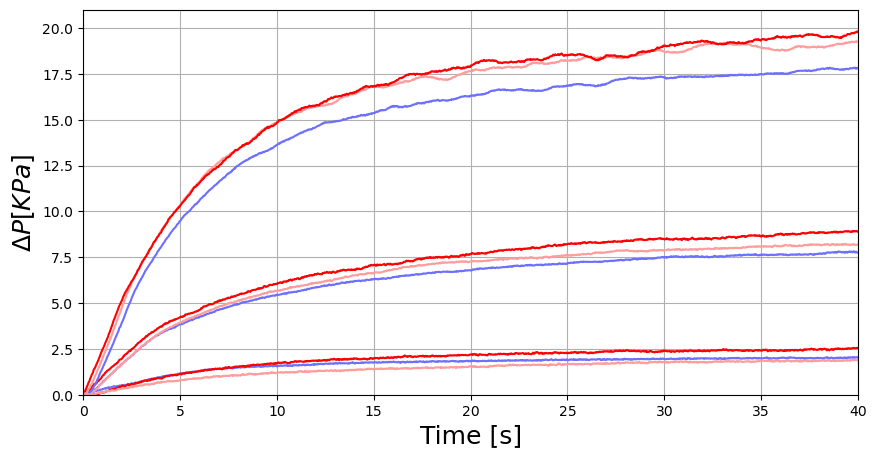

In [ ]:
plt.figure(figsize=(10, 5))
p_final =[]
p_start = []
dp=[]
legend_list=[]
linestyles = ['solid']
colors = ['#6C6FFF', '#FF0000','#6C6FFF','#FF9C9C', '#FF0000','#6C6FFF','#FF9C9C', '#FF0000','#FF9C9C']

for idx,index in enumerate(first_index):
    df = data[0][idx]
    samplename = data[1]['Samplename'][idx] 
    legend_list.append(samplename)
    time = df.Time[index:] - df.Time[index] 
    plt.plot(time,df['MPX100-2'][index:]*1/1000-df['MPX100-2'][index]*1/1000,label=samplename, linestyle=linestyles[idx % len(linestyles)], color=colors[idx % len(colors)])
    p_final.append(data[0][idx]['MPX100-2'].iloc[-1]*1/1000)
    p_start.append(data[0][idx]['MPX100-2'].iloc[first_index[idx]]*1/1000)
   
    
    
# Get current handles and labels
#handles, labels = plt.gca().get_legend_handles_labels()

# Sort them by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# Add to legend
#plt.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(['P = 40', 'P = 60', 'P = 80'],bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim([0,40])
plt.ylim([0, 21])
plt.xlabel("Time [s]",fontsize=18 )
plt.ylabel("$\\Delta P [KPa]$", fontsize=18  )

plt.show()


In [ ]:
labels = dpf['label']
x = np.arange(len(labels))  # the label locations

# Make the subplots
fig, ax = plt.subplots(figsize=(10,6))
ax.grid(True)

width=0.2; 
# Add bars for 'dp_measured' and 'dp_calc'
rects0 = ax.bar(x - width, dpf['p_start'], width, label='p0')
rects1 = ax.bar(x + width, dpf['p_final'], width, label='p1 measured')
rects2 = ax.bar(x , dpf['p_final_calc'], width, label='p1 calculated')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Label')
ax.set_ylabel('kPa')
ax.set_title('dp_measured vs dp_calc')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

NameError: name 'dpf' is not defined

In [ ]:
p0

[38480.00161837716,
 79098.2669838838,
 42609.79906287402,
 60127.560854631774,
 80262.6885571406,
 45615.483781917974,
 68596.70161313016,
 79978.4405659872,
 58800.948405634896]

In [ ]:
dfs[2]['p1']

0    44720.36
1    46196.28
2    47672.20
3    49148.12
4    50624.04
5    52099.96
Name: p1, dtype: float64

In [ ]:
dfs

[   T1        p1    V1    V0    dV  dP [kPa]       p0
 0  30  40386.01  2.17  2.08  0.09      1.91  38480.0
 1  40  41718.88  2.23  2.08  0.15      3.24  38480.0
 2  50  43051.75  2.29  2.08  0.22      4.57  38480.0
 3  60  44384.62  2.36  2.08  0.28      5.90  38480.0
 4  70  45717.49  2.42  2.08  0.34      7.24  38480.0
 5  80  47050.37  2.48  2.08  0.41      8.57  38480.0,
    T1        p1    V1    V0    dV  dP [kPa]        p0
 0  30  83016.19  4.19  4.01  0.19      3.92  79098.27
 1  40  85756.00  4.32  4.01  0.32      6.66  79098.27
 2  50  88495.81  4.45  4.01  0.45      9.40  79098.27
 3  60  91235.62  4.58  4.01  0.58     12.14  79098.27
 4  70  93975.43  4.71  4.01  0.71     14.88  79098.27
 5  80  96715.23  4.84  4.01  0.84     17.62  79098.27,
    T1        p1    V1    V0    dV  dP [kPa]       p0
 0  30  44720.36  2.37  2.27  0.10      2.11  42609.8
 1  40  46196.28  2.44  2.27  0.17      3.59  42609.8
 2  50  47672.20  2.51  2.27  0.24      5.06  42609.8
 3  60  49148.12  2

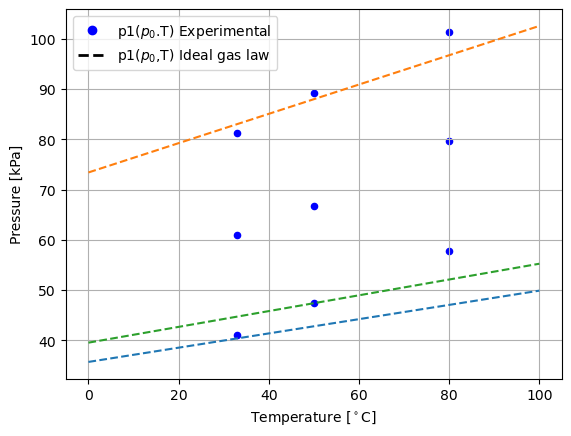

In [ ]:
p = np.zeros((3,2))
for b in [0,1,2]:
    p[b,0] = dfs[b]['p1'][0]/1000
    p[b,1]= dfs[b]['p1'][5]/1000

T_plot = [T1[0], T1[5]]

# Create the plot

dpf.plot(kind='scatter', x='T1', y='p_final',label='p1 Experimental', color='b')

T_ext = np.array([0, 100])  # x-axis limits for line extension

for aa in range(len(p)):
     # Fit a line to your data
    z = np.polyfit(T_plot, p[aa,:], 1)

    # Extend this line to 0 and 100
    p_ext = np.polyval(z, T_ext)
    plt.plot(T_ext, p_ext,linestyle='--',label='p1 ideal gas law')

plt.xlabel("Temperature [$^\circ$C]" )
plt.ylabel("Pressure [kPa]" )
plt.grid()

custom_lines = [Line2D([0], [0], color='b', lw=2, marker='o',linestyle='None'),Line2D([0], [0], color='k', linestyle='--', lw=2)]

plt.legend(custom_lines, ['p1($p_0$.T) Experimental', 'p1($p_0$,T) Ideal gas law'])

# Display the plot
plt.show()


In [ ]:
dfs

[   T1        p1    V1    V0    dV  dP [kPa]       p0
 0  30  40386.01  2.17  2.08  0.09      1.91  38480.0
 1  40  41718.88  2.23  2.08  0.15      3.24  38480.0
 2  50  43051.75  2.29  2.08  0.22      4.57  38480.0
 3  60  44384.62  2.36  2.08  0.28      5.90  38480.0
 4  70  45717.49  2.42  2.08  0.34      7.24  38480.0
 5  80  47050.37  2.48  2.08  0.41      8.57  38480.0,
    T1        p1    V1    V0    dV  dP [kPa]        p0
 0  30  83016.19  4.19  4.01  0.19      3.92  79098.27
 1  40  85756.00  4.32  4.01  0.32      6.66  79098.27
 2  50  88495.81  4.45  4.01  0.45      9.40  79098.27
 3  60  91235.62  4.58  4.01  0.58     12.14  79098.27
 4  70  93975.43  4.71  4.01  0.71     14.88  79098.27
 5  80  96715.23  4.84  4.01  0.84     17.62  79098.27,
    T1        p1    V1    V0    dV  dP [kPa]       p0
 0  30  44720.36  2.37  2.27  0.10      2.11  42609.8
 1  40  46196.28  2.44  2.27  0.17      3.59  42609.8
 2  50  47672.20  2.51  2.27  0.24      5.06  42609.8
 3  60  49148.12  2

In [ ]:
#df2 = pd.read_csv('results.csv', delimiter=';')
df2 = pd.read_csv('T40.txt', delim_whitespace=True)
dt = 1/200;
df2['p2'] = (((df2['MPX100-2[V]'] -V0)/V_range)*p_max)
print(df2)

       presFesto-0[V]  DigOut-1[V]  MPX100-2[V]  HAF075#2-9[V]        p2
0                5.00         4.90         0.26            2.5    168.42
1                5.00         4.90         0.26            2.5    168.42
2                5.01         4.90         0.26            2.5    168.42
3                5.01         4.90         0.26            2.5    168.42
4                5.01         4.90         0.26            2.5    147.37
...               ...          ...          ...            ...       ...
50255            7.01         0.56         2.28            2.5  42694.74
50256            7.01         0.56         2.28            2.5  42736.84
50257            7.01         0.56         2.28            2.5  42736.84
50258            7.01         0.56         2.28            2.5  42778.95
50259            7.01         0.56         2.28            2.5  42736.84

[50260 rows x 5 columns]


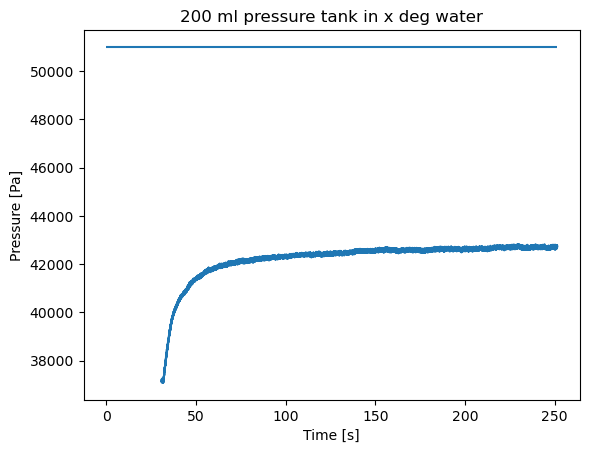

In [ ]:
indices = np.where(df2['DigOut-1[V]']<1)
first_index = indices[0][0]
first_index
time = np.arange(len(df2)) * dt
fig, ax1 = plt.subplots()

plt.title("200 ml pressure tank in x deg water")
ax1.set_xlabel("Time [s]" )
ax1.set_ylabel("Pressure [Pa]" )
ax1.plot(time[-(len(df2['p2'])-first_index):],df2['p2'][first_index:], label='Pressure')
ax1.hlines(51000,time[0],time[-1])



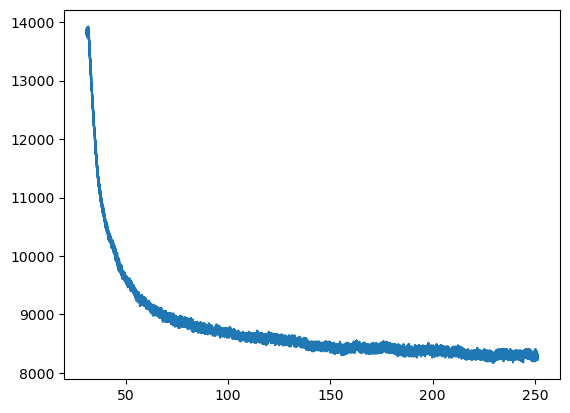

In [ ]:
plt.plot(time[-(len(df2['p2'])-first_index):],-df2['p2'][first_index:]+51000, label='Pressure')
